<a href="https://colab.research.google.com/github/SpreadsheetAaryan/dl_framework_from_scratch/blob/main/demo_of_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/SpreadsheetAaryan/dl_framework_from_scratch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from sklearn.datasets import load_diabetes, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from dl_framework_from_scratch.engine_scalar import Value
from dl_framework_from_scratch.engine_tensor import Tensor
from dl_framework_from_scratch.nn_scalar import Module, Neuron, Layer, MLP_Scalar
from dl_framework_from_scratch.nn_tensor import Module, Linear, MLP_Tensor
from dl_framework_from_scratch.graph import draw_dot_scalar, draw_dot_tensor
%matplotlib inline

In [ ]:
X, y = make_classification(
    n_samples=1000,
    n_features=4,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=3,
    random_state=42
)

print(f"Original dataset shape: X={X.shape}, y={y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(set(y))}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\n--- Dataset Split Summary ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

In [ ]:
scalar_model = MLP_Scalar(4, [64, 3])
tensor_model = MLP_Tensor(4, [64, 3])

In [ ]:
"""
Training Loop using the scalar model
"""

epochs = 20
lr = 1e-3

batch_size = 32

num_samples_train = X_train.shape[0]
num_features = X_train.shape[1]

num_batches_train = num_samples_train // batch_size
if num_samples_train % batch_size != 0:
  num_batches_train += 1

num_samples_test = X_test.shape[0]
num_batches_test = num_samples_test // batch_size
if num_samples_test % batch_size != 0:
  num_batches_test += 1

losses_train = []
losses_test = []
accuracy = []

def softmax(y_pred):
  exp_logits = [val.exp() for val in y_pred]
  x = Value(0.0)
  for val in exp_logits:
    x += val
  probabilities = []
  for val in exp_logits:
    probabilities.append(val / x)
  return probabilities

def categorical_cross_entropy(y_true_index_value, y_pred_probs_list):
    true_class_idx = int(y_true_index_value.data)
    predicted_prob_for_true_class = y_pred_probs_list[true_class_idx]

    loss = predicted_prob_for_true_class.ln() * Value(-1.0)
    return loss

start_time = time.time()

for j in range(epochs):

  permutation = np.random.permutation(num_samples_train)
  X_shuffled_train = X_train[permutation]
  y_shuffled_train = y_train[permutation]

  epoch_loss_train = Value(0.0)
  epoch_loss_test = Value(0.0)


  # Train
  for i in range(num_batches_train):
    scalar_model.zero_grad()
    batch_loss_train = Value(0.0)

    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples_train)

    X_batch = X_shuffled_train[start_idx:end_idx]
    y_batch = y_shuffled_train[start_idx:end_idx]

    for (x_sample, y_sample) in zip(X_batch, y_batch):
      x_sample = [Value(val) for val in x_sample]
      y_sample = Value(y_sample)
      y_pred_raw = scalar_model(x_sample)
      y_pred = softmax(y_pred_raw)
      loss_for_sample = categorical_cross_entropy(y_sample, y_pred)
      batch_loss_train += loss_for_sample
    epoch_loss_train += batch_loss_train
    batch_loss_train.backward()
    for p in scalar_model.parameters():
        p.data -= lr * p.grad


  # Test
  total_correct = 0
  for i in range(num_batches_test):
    batch_loss_test = Value(0.0)

    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples_test)

    X_batch = X_test[start_idx:end_idx]
    y_batch = y_test[start_idx:end_idx]

    for (x_sample, y_sample) in zip(X_batch, y_batch):
      x_sample = [Value(val) for val in x_sample]
      y_sample = Value(y_sample)
      y_pred_raw1 = scalar_model(x_sample)
      y_pred_raw2 = softmax(y_pred_raw1)
      loss_for_sample = categorical_cross_entropy(y_sample, y_pred_raw2)
      batch_loss_test += loss_for_sample
      predicted_probs_data = [p.data for p in y_pred_raw2]
      predicted_class_idx = np.argmax(predicted_probs_data)
      if predicted_class_idx == y_sample.data:
          total_correct += 1
    epoch_loss_test += batch_loss_test



  print(f'Epoch {j + 1}')

  acc = total_correct / num_samples_test
  print(f'Accuracy: {acc}')
  accuracy.append(acc)

  avg_loss_train = epoch_loss_train.data / num_batches_train
  print(f'Train Loss: {avg_loss_train}')
  losses_train.append(avg_loss_train)

  avg_loss_test = epoch_loss_test.data / num_batches_test
  print(f'Test Loss: {avg_loss_test}')
  losses_test.append(avg_loss_test)

  print()


end_time = time.time()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses_train, label='Train Loss', color='blue')
plt.plot(range(epochs), losses_test, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), accuracy, label='Test Accuracy', color='green')
plt.title('Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


total_training_time = end_time - start_time
minutes = int(total_training_time // 60)
seconds = total_training_time % 60
print(f"Total training time: {minutes} minutes and {seconds:.2f} seconds")
# Total training time: 10 minutes and 51.86 seconds

In [ ]:
"""
Training Loop using the tensor model
"""

epochs = 100
lr = 0.001
batch_size = 64

num_samples_train = X_train.shape[0]
num_features = X_train.shape[1]

num_batches_train = num_samples_train // batch_size
if num_samples_train % batch_size != 0:
  num_batches_train += 1

num_samples_test = X_test.shape[0]
num_batches_test = num_samples_test // batch_size
if num_samples_test % batch_size != 0:
  num_batches_test += 1

losses_train = []
losses_test = []
accuracy = []


def softmax(y_pred_raw_logits):
    max_logits = y_pred_raw_logits.max(axis=1, keepdims=True)
    stable_logits = y_pred_raw_logits - max_logits

    exp_logits = stable_logits.exp()

    sum_exp_logits = exp_logits.sum(axis=1, keepdims=True)

    probabilities = exp_logits / sum_exp_logits
    return probabilities

def categorical_cross_entropy_loss(y_true_indices_batch, y_pred_probs_batch):
    num_samples = y_true_indices_batch.data.shape[0]
    num_classes = y_pred_probs_batch.data.shape[1]
    y_true_one_hot_np = np.zeros((num_samples, num_classes), dtype=np.float64)
    y_true_one_hot_np[np.arange(num_samples), y_true_indices_batch.data.flatten().astype(int)] = 1.0
    y_true_one_hot_tensor = Tensor(y_true_one_hot_np, requires_grad=False)
    masked_probs = y_pred_probs_batch * y_true_one_hot_tensor

    epsilon = 1e-9
    selected_probs_for_log = masked_probs.sum(axis=1, keepdims=False) + Tensor(epsilon, requires_grad=False)
    loss_per_sample = selected_probs_for_log.ln() * Tensor(-1.0, requires_grad=False)
    average_loss = loss_per_sample.sum() / num_samples
    return average_loss


start_time = time.time()


for j in range(epochs):

  permutation = np.random.permutation(num_samples_train)
  X_shuffled = X_train[permutation]
  y_shuffled = y_train[permutation]

  epoch_loss_train = 0
  epoch_loss_test = 0


  # Train
  for i in range(num_batches_train):
    tensor_model.zero_grad()

    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples_train)

    X_batch = X_shuffled[start_idx:end_idx]
    y_batch = y_shuffled[start_idx:end_idx]

    X_batch = Tensor(X_batch, requires_grad=True)
    y_batch = Tensor(y_batch.reshape(-1, 1))


    y_pred_raw = tensor_model(X_batch)
    y_pred = softmax(y_pred_raw)
    batch_loss_train = categorical_cross_entropy_loss(y_batch, y_pred)
    epoch_loss_train += batch_loss_train.data

    batch_loss_train.backward()
    for p in tensor_model.parameters():
      p.data -= lr * p.grad


  # Test
  total_correct = 0
  for i in range(num_batches_test):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples_test)

    X_batch = X_test[start_idx:end_idx]
    y_batch = y_test[start_idx:end_idx]

    X_batch = Tensor(X_batch, requires_grad=False)
    y_batch = Tensor(y_batch.reshape(-1, 1), requires_grad=False)

    y_pred_raw = tensor_model(X_batch)
    y_pred = softmax(y_pred_raw)

    predicted_classes = y_pred.data.argmax(axis=1)
    true_classes = y_batch.data.flatten()
    corr = np.sum(predicted_classes == true_classes)
    total_correct += corr

    batch_loss_test = categorical_cross_entropy_loss(y_batch, y_pred)
    epoch_loss_test += batch_loss_test.data


  print(f'Epoch {j + 1}')

  acc = total_correct / num_samples_test
  print(f'Accuracy: {acc}')
  accuracy.append(acc)

  avg_loss_train = epoch_loss_train / num_batches_train
  print(f'Train Loss: {avg_loss_train}')
  losses_train.append(avg_loss_train)

  avg_loss_test = epoch_loss_test / num_batches_test
  print(f'Test Loss: {avg_loss_test}')
  losses_test.append(avg_loss_test)

  print()


end_time = time.time()


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), losses_train, label='Train Loss', color='blue')
plt.plot(range(epochs), losses_test, label='Test Loss', color='red')
plt.title('Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(epochs), accuracy, label='Test Accuracy', color='green')
plt.title('Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


total_training_time = end_time - start_time
minutes = int(total_training_time // 60)
seconds = total_training_time % 60
print(f"Total training time: {minutes} minutes and {seconds:.2f} seconds")
# Total training time: 0 minutes and 2.36 seconds

# **Scalar Model**

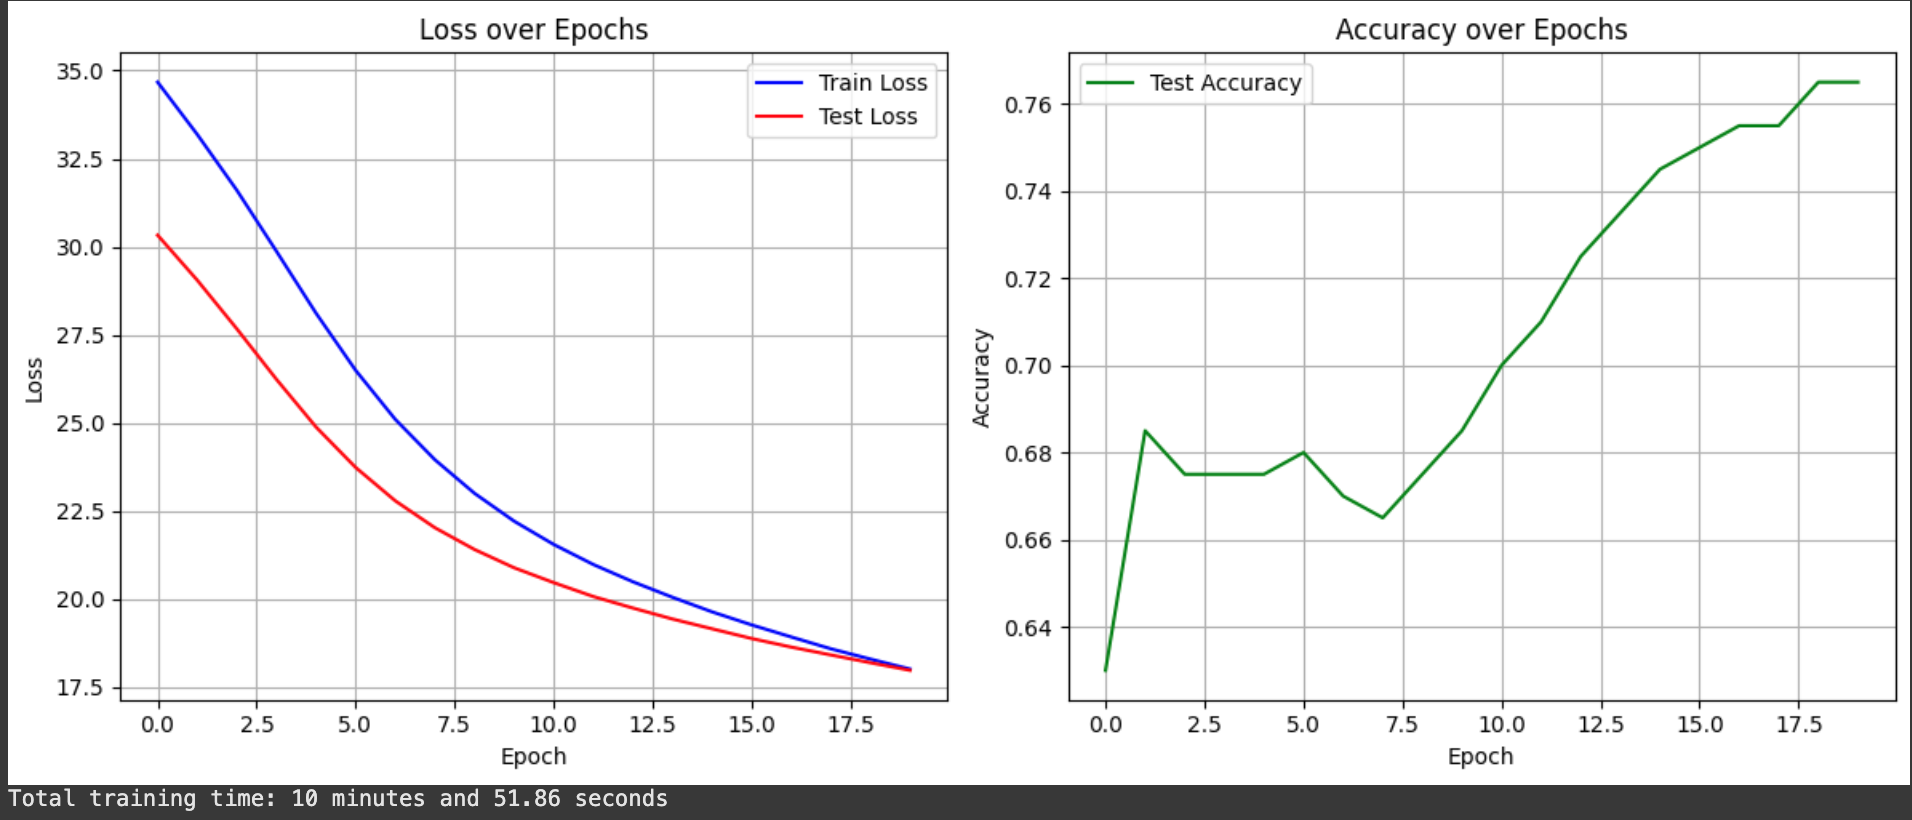

# **Tensor Model**

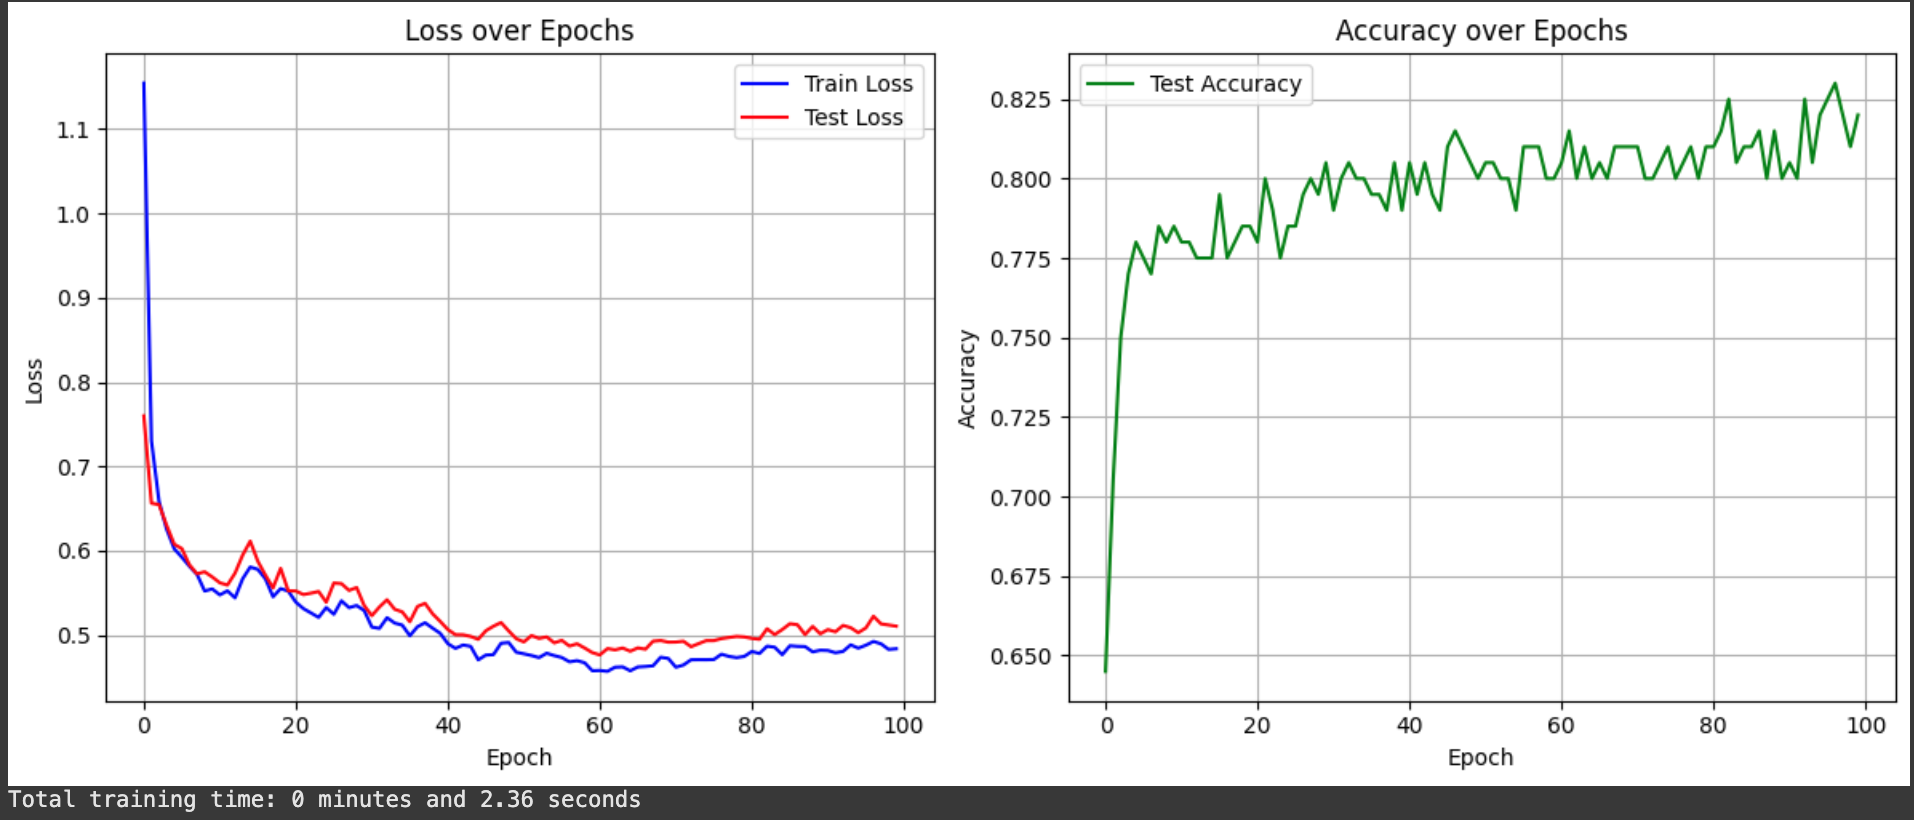

# **Project** **Reflection**

# From Scalar Autograd to a Custom Tensor Framework

My journey into the complex world of deep learning got really exciting when I decided to see how it all truly worked and build a deep learning system myself from the very beginning. This project wasn't just about writing code for rules; it was about really exploring the basic math and computer ideas that make today's AI work.

**Phase 1: Autograd with Scalar Operations (Inspired by Micrograd)**

My first idea came from a really helpful video by Andrej Karpathy. He explained how a computer can automatically figure out how much each small change affects the final answer. This made me want to build that core idea myself. So, starting from the very basics, I made a simple version of this autograd system.

This first part was super important. I carefully made a "Value" class, which was like the smallest building block of my math map. Each "Value" number held its actual number, but also its gradient, a link to the "Value" numbers that came before it, and what math step made it. This let me:

- Construct a Dynamic Computational Graph: Every arithmetic operation (+, *, exp, ln, pow, etc.) on Value objects automatically added nodes and edges to this graph, tracking dependencies.

- Implement the Chain Rule: The heart of backpropagation. For each operation, I defined a _backward() method. When called, this method applied the chain rule, multiplying the incoming gradient (out.grad) by the local derivative of the operation with respect to its inputs, and accumulating these contributions onto the grad of the parent Values. This solidified my understanding of how gradients flow backward through complex computations.

- Master Topological Sort: A critical component for ensuring correct gradient propagation. Before the backward pass, I implemented a topological sort algorithm to order the Value objects. This ensured that the _backward() method of a Value was only called after all gradients from its dependent (child) operations had been computed and accumulated, guaranteeing accurate gradient updates.

With this scalar autograd in place, I successfully built and trained a small neural network. It was incredibly rewarding to see gradients flow and the model learn, but a significant challenge quickly emerged: speed.

**Phase 2: Autograd with Tensors and Matrix Calculus**

While that simple autograd system was great for learning, it was just too slow for real AI jobs, which use huge matrices. My next big goal was to make learning much, much faster by building a new autograd system based on Tensors.

This was a big jump into harder stuff. It meant I really needed to understand "matrix calculus" – which is just how you figure out the gradients for operations when you're working with matrices, not just scalars. I dug deep into the tricky parts of:

- Derivatives of matrix multiplication.

- Gradients of summation and reduction operations across dimensions.

- Broadcasting rules and their impact on gradient shapes.

My new Tensor class was designed to handle multi-dimensional arrays, with operations like exp(), sum(), max(), and element-wise arithmetic now working across entire tensors. I also integrated features common in production frameworks:

- requires_grad: Allowing selective tracking of gradients, crucial for memory optimization and distinguishing trainable parameters from constant inputs.

- Optimized Operations: Implementing sum(), max(), and other reduction/element-wise methods to correctly compute values and set up their corresponding _backward() functions for tensor gradients.

**Phase 3: Problem with Broadcasting**

The transition to tensors wasn't without challenges. I hit a significant roadblock when dealing with NumPy broadcasting (or the equivalent logic in a custom tensor implementation). Operations like adding a scalar to a matrix, or adding matrices of different but compatible shapes, require careful handling of gradient propagation. I had to thoroughly understand:

What broadcasting is: How NumPy implicitly expands dimensions to make shapes compatible for element-wise operations.

How it affects gradients: When backpropagating through a broadcasted operation, gradients need to be correctly summed or "reduced" along the dimensions that were broadcasted in the forward pass. This required careful implementation of _backward() methods for operations involving broadcasting.

Learning and fixing this specific issue was a testament to the iterative nature of software development and problem-solving in deep learning.

**Phase 4: Training Both Models**

Finally, I put both my scalar and tensor frameworks to the test by training classification models custom datasets. Here are the results:

- Scalar Model: Trained for 20 epochs, it took approximately 10 minutes and 51.86 seconds.

- Tensor Model: Trained for 100 epochs (5x more iterations), it completed in just 2.36 seconds.

This showed a huge jump in how fast the AI could learn. It proved how much power and speed you get by moving from working with scalars to working with tensors. Plus, the tensor-based AI actually learned just as well, or even better, in a tiny fraction of the time. This showed that being fast doesn't mean you have to be less accurate.

This project was a super valuable experience. It really made me understand how AI learns automatically, how math steps are mapped out, and the small tricks that make AI programs run fast. It gave me a deep respect for how clever and complicated today's AI systems are. It also made me much better at solving problems on my own, using math, and making things run faster. I'm really excited to use these basic ideas to take on even harder AI challenges.